In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/waveforms.pt
/kaggle/input/train_meta.csv


In [2]:
!git clone https://github.com/shonenkov/asr-shad > /dev/null
!pip install -r './asr-shad/requirements.txt' > /dev/null
import sys
sys.path.insert(0, './asr-shad/utils')

Cloning into 'asr-shad'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 477 (delta 0), reused 0 (delta 0), pack-reused 476
Receiving objects: 100% (477/477), 4.34 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (284/284), done.
ERROR: tpot 0.11.5 has requirement scikit-learn>=0.22.0, but you'll have scikit-learn 0.21.3 which is incompatible.
ERROR: osmnx 0.15.1 has requirement geopandas>=0.7, but you'll have geopandas 0.6.3 which is incompatible.
ERROR: osmnx 0.15.1 has requirement numpy>=1.18, but you'll have numpy 1.17.2 which is incompatible.
ERROR: kornia 0.3.1 has requirement torch==1.5.0, but you'll have torch 1.5.1 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.17.2 which is incompatible.
ERROR: kmeans-smote 0.1.2 has requirement scikit-l

# ASR Numbers
## Наивные модели

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torchaudio
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from audio_stats import get_audio_stats
from int_to_text import num2text
from metrics import mean_wer, mean_ser

# Описание гипотезы 

(объяснение постановки задачи машинного обучения с учителем: вход --> выход)

Первое приближение. Будем решать задачу регрессии - предсказывать число по аудиозаписи. Применим для начала линейную регрессию.

# Реализация

(код)

Скачаем заранее подготовленные метаданные и статистику по датасету, оставим среди признаком только gender и frames, длительность и размер удалим, так как они хорошо скоррелированы с количеством фреймов. Добавим в train средние кепстральных коэффициентов.

In [ ]:
# don't run

train = pd.read_csv(INPUT_DIR + '/numbers/train.csv')
train_stats = pd.read_csv(INPUT_DIR + '/train_audio_stats.csv')

train['gender'] = train['gender'].apply(lambda x: 1 if x == 'female' else -1)
train_stats['filename'] = train_stats['filename'].apply(lambda x: 'train/' + x)
train_stats = train_stats[['filename', 'frames']]
train = train.merge(train_stats, left_on='path', right_on='filename')
train = train[['path', 'gender', 'frames', 'number']]

def get_waveform(path):
    waveform, _ = torchaudio.load(INPUT_DIR + '/numbers/' + path)
    return waveform   

waveforms = []
for p in train['path']:
    waveforms.append(get_waveform(p)) 

torch.save(waveforms, 'waveforms.pt')
train.to_csv('train_meta.csv', index=False)

In [4]:
# for the sake of performance download this data prepared in advance
train = pd.read_csv('/kaggle/input/train_meta.csv')
waves = torch.load('/kaggle/input/waveforms.pt')

In [5]:
# check myself

# train.shape
# train.head()
# len(waves)
# type(waves), type(waves[0])
# plt.plot(waves[0].t().numpy())

,path,gender,frames,number
0,train/e332b996d3.wav,1,56923,157105
1,train/e25afda49a.wav,1,80659,374554
2,train/364f147340.wav,-1,84807,688694
3,train/5e0954b206.wav,1,80601,265381
4,train/7130a67690.wav,-1,72957,955415


Средние для кепстральных коэффициентов:

In [6]:
def wave_to_mfcc(waveform):
    specgram = torchaudio.transforms.MFCC()(waveform)
    mean_mfcc = torch.mean(specgram, 1)
    return list(np.array(mean_mfcc.flatten()))

mfcc_means = [wave_to_mfcc(waveform) for waveform in waves]

In [7]:
mfcc_df = pd.DataFrame(mfcc_means)
train_mfcc = pd.concat([train, mfcc_df], axis=1)
train_mfcc.fillna(0, inplace=True)

X = train_mfcc[['gender','frames'] + list(range(mfcc_df.shape[1]))]
y = train['number']

Обучим линейный регрессор, посчитаем для предсказаний среднюю абсолютную ошибку.

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

param_grid = [{'penalty': ['l2', 'l1', 'elasticnet'], 
               'alpha': [0.0001, 0.001, 0.01, 0.1], 
               'warm_start': [True, False]}]

searcher = GridSearchCV(SGDRegressor(loss='squared_loss', random_state=42), 
                        param_grid, cv=5, scoring='neg_mean_absolute_error')
start = time.time()
searcher.fit(X, y)
print(time.time() - start)

42.86985445022583


In [13]:
searcher.best_params_, searcher.best_score_

({'alpha': 0.1, 'penalty': 'l2', 'warm_start': True}, -19492936160.51572)

Попробуем случайный лес. На части датасета случайный лес дает MAE порядка $2 \cdot 10^5$ (у линейного регрессора выше $2\cdot 10^{10}$), это значительное улучшение, также на малой подвыборке подбираем гиперпараметры.

In [14]:
param_grid = [{'criterion': ['mae', 'mse'], 
               'max_depth': [2, 3, 5, 10, 15, 20], 
               'n_estimators': [100, 200],
              }]

searcher = GridSearchCV(RandomForestRegressor(n_jobs=4, random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error')

start = time.time()
searcher.fit(X[:100, :], y[:100])
print('Random Forest fitting time = ', time.time() - start)

Random Forest fitting time =  160.35234713554382


In [15]:
searcher.best_params_, searcher.best_score_

({'criterion': 'mae', 'max_depth': 15, 'n_estimators': 100}, -207432.4473)

На маленькой подвыборке подобраны гиперпараметры: criterion=mae, max_depth=15, n_estimators=100. 
Обучим случайный лес с этими параметрами на 3/4 элементах датасета, провалидируем на остальных.

In [16]:
regressor = RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=15, warm_start=True, n_jobs=4, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

start = time.time()
regressor.fit(X_train, y_train)
print('Random Forest fitting time =', time.time() - start)

Random Forest fitting time = 2091.8834352493286


In [17]:
y_pred = regressor.predict(X_test)
score = mean_absolute_error(y_test, y_pred)
score_fit = mean_absolute_error(y_train, regressor.predict(X_train))
score, score_fit

(22938.015215555555, 9946.760437777777)

Видим, что на всем датасете MAE уменьшилась еще в десять раз.
Посмотрим, что этот результат значит для фраз и целевой метрики

In [18]:
m = mean_wer([num2text(x) for x in y_test], [num2text(round(x, 0)) for x in y_pred])
s = mean_ser([num2text(x) for x in y_test], [num2text(round(x, 0)) for x in y_pred])
m, s

(0.7720624338624387, 0.5142236185981031)

In [19]:
phrases = pd.DataFrame({'reference': [num2text(x) for x in y_test],
                        'prediction': [num2text(round(x, 0)) for x in y_pred],
    
})
phrases.head(20)

,reference,prediction
0,семьсот пятьдесят семь тысяч сто двадцать четыре,семьсот пятьдесят тысяч семьсот семьдесят восемь
1,пятьдесят девять тысяч двадцать два,восемьдесят тысяч шестьсот девяносто девять
2,семьсот сорок тысяч семьсот шестьдесят семь,шестьсот восемьдесят три тысячи девятьсот пять...
3,сто шестьдесят четыре тысячи шестьсот шестьдес...,сто шестьдесят четыре тысячи семьсот девяносто...
4,восемьсот сорок тысяч пятьсот пятьдесят три,восемьсот тридцать три тысячи восемьсот девять
5,пятьсот тридцать пять тысяч восемьсот восемьде...,пятьсот сорок шесть тысяч сто сорок пять
6,семьсот семьдесят девять тысяч пятьсот пятьдес...,семьсот шестьдесят тысяч семьсот пятьдесят шесть
7,четыреста пятьдесят пять тысяч восемьдесят один,четыреста пятьдесят одна тысяча четыреста пять...
8,восемьсот пятьдесят шесть тысяч девятьсот трид...,семьсот восемьдесят одна тысяча девятьсот восемь
9,триста девяносто семь тысяч шестьсот десять,триста восемьдесят пять тысяч семьсот шесть


Попробуем другую стратегию: определять каждое слово при помощи деревьев. Тогда появляется подзадача по классификации на 41 класс (всего в датасете 41 слово). Также нужно научиться разделять фичи из MFCC на слова. Будем делить на слова список ненулевых коэффициентов равномерно, в трейне можно легко определить количество слов по числу, в тесте обучим модель, которая будет определять количество слов. Здесь линейная модель, зависящая от пола и количества фреймов, кажется разумной эвристикой. Действительно,  

In [20]:
y_text = np.array([num2text(x) for x in y])
y_length = np.array([len(x.split()) for x in y_text])

In [24]:
X = train[['gender','frames']]
scaler = StandardScaler()
X = scaler.fit_transform(X)

param_grid = [{'penalty': ['l2', 'none'],
               'multi_class': ['ovr', 'multinomial'],
               'C': [0.01, 0.1, 10], 
               'warm_start': [True, False],
              }]

length_classifier = GridSearchCV(LogisticRegression(solver='saga', random_state=42), 
                                 param_grid, cv=5, scoring='neg_mean_absolute_error')

length_classifier.fit(X, y_length)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarni

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converg

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converg

Length defining regressor fitting time = 31.573340892791748


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [25]:
length_classifier.best_params_, length_classifier.best_score_

({'C': 0.01,
  'multi_class': 'multinomial',
  'penalty': 'none',
  'warm_start': True},
 -0.314)

Теперь напишем функции для обучения и предсказания на каждом шаге кроссвалидации.

In [26]:
COL_PER_WORD = 61

corpus = list(set(word for string in [num2text(x) for x in y] for word in string.split()))
word_to_class = {corpus[i]: i for i in range(len(corpus))}
class_to_word = {i: corpus[i] for i in range(len(corpus))}

In [27]:
def fit_classifier(clf, indices, X, y):
    train = []
    target = []
    for i in indices:
        phrase = list(num2text(y[i]).split())
        length = len(phrase)
        for j in range(length):
            cur_dict = {'gender': X.at[i, 'gender'], 'frames': X.at[i, 'frames']}
            cur_dict.update({idx: X.at[i, idx + j * COL_PER_WORD] for idx in range(COL_PER_WORD)})
            train.append(cur_dict)
            target.append(word_to_class[phrase[j]])
    
    train = pd.DataFrame(train) 
    target = np.array(target)
    train.fillna(0, inplace=True)
    clf.fit(train, target)
    return clf

def predict_phrases(clf, length_clf, indices, X):
    y_pred = []
    for i in indices:
        num_words = length_clf.predict(pd.DataFrame({'gender': [X.at[i, 'gender']], 'frames': [X.at[i, 'frames']]}))
        prediction = ''
        for j in range(int(num_words)):
            cur_dict = {'gender': [X.at[i, 'gender']], 'frames': [X.at[i, 'frames']]}
            cur_dict.update({idx: [X.at[i, idx + j * COL_PER_WORD]] for idx in range(COL_PER_WORD)})
            cur_df = pd.DataFrame(cur_dict)
            cur_pred = clf.predict(cur_df)[0]
            prediction += (class_to_word[cur_pred])
            prediction += ' '
        y_pred.append(prediction[:-1])
    return np.array(y_pred)

Реализуем кросс-валидацию на 3 фолдах.

In [38]:
X = train_mfcc[['gender','frames'] + list(range(mfcc_df.shape[1]))]
y = train['number']

y_crosswal_pred = []

start = time.time()
for i in range(3):
    clf = RandomForestClassifier(random_state=42)
#    clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=15, random_state=42)
    clf = fit_classifier(clf, [x for x in range(9000) if x not in range(3000 * i, 3000 * i + 3000)], X, y)
    y_pred = predict_phrases(clf, length_classifier, [x for x in range(3000 * i, 3000 * i + 3000)], X)
    y_crosswal_pred += list(y_pred)
print('Random forest classifier fitting time =', time.time() - start)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random forest classifier fitting time = 638.8470225334167


Параметры: n_estimators=100, criterion='gini', max_depth=15.

In [29]:
mean_wer(y_crosswal_pred, y_text), mean_ser(y_crosswal_pred, y_text)

(0.6049206349206062, 0.447248377170323)

С дефолтными параметрами лучше:

In [39]:
mean_wer(y_crosswal_pred, y_text), mean_ser(y_crosswal_pred, y_text)

(0.568507936507922, 0.39320905609289897)

# Предикт

(получение финального csv с OOF предиктом, три столбика: reference, prediction, filename - все поля текстовые)

In [40]:
ans = pd.DataFrame({'path': train['path'],
                    'reference': y_text,
                    'prediction': y_crosswal_pred    
})
ans.head(20)

,path,reference,prediction
0,train/e332b996d3.wav,сто пятьдесят семь тысяч сто пять,сто пятьдесят три тридцать шесть шесть шесть
1,train/e25afda49a.wav,триста семьдесят четыре тысячи пятьсот пятьдес...,триста двести семьдесят тысячи пятьсот три восемь
2,train/364f147340.wav,шестьсот восемьдесят восемь тысяч шестьсот дев...,шестьсот восемьдесят восемь сорок тысяч четыре...
3,train/5e0954b206.wav,двести шестьдесят пять тысяч триста восемьдеся...,двести шестьдесят пять шестьсот тысяча тысячи ...
4,train/7130a67690.wav,девятьсот пятьдесят пять тысяч четыреста пятна...,девятьсот пятьдесят пять тысяч четыреста шесть...
5,train/5e39a8735b.wav,четыре тысячи двести восемьдесят,четыреста семьдесят две тридцать семь два два
6,train/14b99654c7.wav,пятьсот четырнадцать тысяч шестьсот семьдесят ...,пятьсот четырнадцать тысяч тысяч шесть четыре ...
7,train/d004a14da0.wav,восемьсот тысяч триста пятьдесят два,восемьсот тысяч триста тысяч два семь семь
8,train/d0b0aa52e0.wav,девяносто четыре тысячи семьсот двадцать семь,восемьсот четыре девятьсот тысяч восемьдесят о...
9,train/48a917e81b.wav,семьсот пятьдесят три тысячи восемьсот восемьд...,семьсот пятьдесят тридцать тысяч восемь пятьде...


# Оценка качества

(подсчет целевых метрик word error rate и symbol (char) error rate)

Качество на валидации: 

$WER=0.568507936507922,$ $SER=0.39320905609289897$.

Также интересно посмотреть на ошибки на разных словах (судя по табличке выше, чем больше номер слова, тем сильнее ошибается модель).

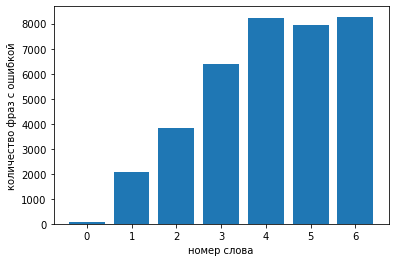

In [41]:
errors = [0] * 7
for i in range(ans.shape[0]):
    ref = list(ans.at[i, 'reference'].split())
    pred = list(ans.at[i, 'prediction'].split())
    for j in range(max(len(ref), len(pred))):
        if j < min(len(ref), len(pred)):
            errors[j] += (ref[j] != pred[j])
        elif j >= len(ref) or j >= len(pred):
            errors[j] += 1
            
plt.bar(list(range(7)), errors)
plt.xlabel('номер слова')
plt.ylabel('количество фраз с ошибкой')
plt.show()

# Субъективная оценка

(почему не сработало или сработало, дальнейшее развитие подхода)

Деревья неплохо способны определять отдельные слова, но для работы с фразами нужен более тонкий препроцессинг для разделения фраз на слова. Равномерная разбивка - эвристика, которая хорошо могла бы сработать только на очень коротких фразах. Видно, что к третьему слову в 44% фраз алгоритм ошибается. 

В этом подходе направления, в котором требуются усовершенствования - более точное определение количества слов, определение длин слов во фразе.

Еще одно направление, в котором можно сформулировать и проверить много гипотез: генерация фичей, а именно, какие преобразования аудиосигнала использовать для обучения модели.